In [1]:

%%bash
git clone https://github.com/ronakdm/input-marginalization.git
cd input-marginalization
git pull
cd ..

Already up to date.


Cloning into 'input-marginalization'...


In [2]:
try:
    from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
except ModuleNotFoundError:
    !pip install transformers
    from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup, BertForMaskedLM

     |████████████████████████████████| 2.1MB 13.9MB/s 
     |████████████████████████████████| 3.2MB 48.1MB/s 
     |████████████████████████████████| 890kB 44.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=f0db41ca8cb9bcde78e6d0d8d550ee75230e33b05d9bdd0b1e38e348a8f0b53b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import torch
import sys
path = ("input-marginalization")
if path not in sys.path:
    sys.path.insert(0, path)

In [4]:
!pip install pytorch_pretrained_bert

     |████████████████████████████████| 133kB 14.5MB/s 
     |████████████████████████████████| 133kB 23.1MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 7.3MB 12.9MB/s 
ERROR: botocore 1.20.29 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [18]:
from metrics import zero_erasure, unk_erasure, colored_sentence, encode, erasure, input_marginalization,continuous_colored_sentence
from utils import generate_dataloaders, train, test,load_dataset


In [6]:
BATCH_SIZE = 1
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print("Running on '%s'." % device)

Running on 'cuda'.


In [7]:
from google.colab import drive
drive.mount('/content/gdrive')
save_dir = "/content/gdrive/My Drive/input-marginalization"

Mounted at /content/gdrive


In [8]:
train_dataloader, validation_dataloader, test_dataloader = generate_dataloaders(BATCH_SIZE)

6,919 training samples.
  876 validation samples.
1,822 test samples.


In [99]:
sentences = [
  "a good piece of work more often than not .",
  "it ' s also , clearly , great fun .",
  "the best film about baseball to hit theaters since field of dreams .",
  "it ' s a bit disappointing that it only manages to be decent instead of dead brilliant ."
]


In [20]:
cnn = torch.load(f"{save_dir}/cnn_sst2.pt")

bert = torch.load(f"{save_dir}/bert_sst2.pt")

lstm_sst2 = torch.load(f"{save_dir}/lstm_sst2.pt").to(device)


In [157]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
vocab = tokenizer.vocab
from torch.nn import LogSoftmax
from torch.nn import Softmax
# TODO: Make this work for batches.
def erasure(model, sentence, special_token, target_label=None):
    device = "cuda" if next(model.parameters()).is_cuda else "cpu"
    input_ids, attention_masks, labels = encode(sentence, device)
    seq_len = input_ids.shape[1]
    model.eval()

    att_scores = torch.zeros(input_ids.shape)
    with torch.no_grad():

        logits_true = model(
            input_ids, attention_mask=attention_masks, labels=labels,
        ).logits[0]

        if target_label is None:
            target_label = torch.argmax(logits_true)
        #print(target_label)
        log_odds_true = LogSoftmax(dim=0)(logits_true)[target_label] - math.log(1-Softmax(dim=0)(logits_true)[target_label])
        

        
        for t in range(seq_len):
            temp = input_ids[0, t].item()  # item() to pass by value.
            input_ids[0, t] = vocab[special_token]
            logits = model(
                input_ids, attention_mask=attention_masks, labels=labels,
            ).logits[0]

            att_scores[0, t] = log_odds_true - (LogSoftmax(dim=0)(logits)[target_label]-math.log(1-Softmax(dim=0)(logits)[target_label]))
            input_ids[0, t] = temp  # Change token back after replacement.

        return att_scores


In [154]:
for sentence in sentences:
    
    print(sentence)
    #bert +zero 
    #print(erasure(lstm_sst2, sentence, "[PAD]"))
    colored_sentence(sentence,erasure(lstm_sst2, sentence, "[PAD]"))
    #print(input_marginalization(cnn, sentence, mlm))
    #BERT + input-marginalization
    colored_sentence(sentence,input_marginalization(lstm_sst2, sentence, mlm))

a good piece of work more often than not .
tensor(1, device='cuda:0')
 a good piece of work more often than not .
 a good piece of work more often than not .
it ' s also , clearly , great fun .
tensor(1, device='cuda:0')
 it ' s also , clearly , great fun .
 it ' s also , clearly , great fun .
the best film about baseball to hit theaters since field of dreams .
tensor(1, device='cuda:0')
 the best film about baseball to hit theaters since field of dreams .
 the best film about baseball to hit theaters since field of dreams .
it ' s a bit disappointing that it only manages to be decent instead of dead brilliant .
tensor(1, device='cuda:0')
 it ' s a bit disappointing that it only manages to be decent instead of dead brilliant .
 it ' s a bit disappointing that it only manages to be decent instead of dead brilliant .


In [242]:
#make a subset of 700 test_dataset

#generate 700 random numbers
import random
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

test_dataset = load_dataset("test")
randomlist = random.sample(range(len(test_dataset)), 700)

test_subset = torch.utils.data.Subset(test_dataset, randomlist)
test_subloader = DataLoader(
        test_subset, sampler=RandomSampler(test_subset), batch_size=BATCH_SIZE
    )
print("{:>5,} test samples.".format(len(test_subset)))

  700 test samples.


In [215]:
from transformers import BertForMaskedLM
mlm = BertForMaskedLM.from_pretrained('bert-base-uncased').cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [203]:
def compute_probability2(model, input_ids, attention_masks, label):
  
    logits = model(
        input_ids.to(torch.int64), attention_mask=attention_masks, labels=label.repeat((len(input_ids))),
    ).logits
    probabilitydist = F.softmax(logits, dim=1)
    return torch.reshape(probabilitydist[:, label], (-1,))


In [237]:
def calculate_woe(model, input_ids, attention_masks, label, sigma):
  device = "cuda" if next(model.parameters()).is_cuda else "cpu"
  
  bert_model.to(device)
  
  #predictions is the probability distribution of each word in the vocabulary for each word in input sentence
  predictions = mlm(input_ids)
 
  predictions = torch.squeeze(predictions[0])
  predictions = F.softmax(predictions, dim=1)

  #woe is the weight of evidence
  woe = []
  model.eval()

  with torch.no_grad():
    for j in range (len(predictions)):
      word_scores = predictions[j]
      input_batch = input_ids.clone().to(device)
      
      #word_scores_batch calculates the value of the MLM of Bert for each masked word
      #we put 0 for the first input which is unmasked
      word_scores_batch = [0]

      for k in range(len(word_scores)):
        if word_scores[k] > sigma:
           input_batch = torch.cat((input_batch, input_ids), 0)
           input_batch[len(input_batch)-1][j] = k
           word_scores_batch.append(word_scores[k].item())
      
      #probability_input calculates the p(label|sentence) of the target model given each masked input sentence
      probability_input = compute_probability2(model, input_batch, attention_masks, label)
      m = torch.dot(torch.tensor(word_scores_batch).to(device), probability_input)
      logodds_input = math.log(probability_input[0] / (1-probability_input[0]))
      logodds_m = math.log(m / (1-m))
      woe.append(logodds_input-logodds_m)
  return woe

In [243]:
from termcolor import colored
import numpy as np
import math

from itertools import chain
import torch.nn.functional as F

SIGMA = 1e-4

def AUC_store(model):
    #create 2d numpy array to store probability for predicted class
    zero_p = np.zeros((700,14))
    mag_p = np.zeros((700,14))
    unk_p = np.zeros((700,14))
    for idx,batch in enumerate(test_subloader,0):
        tokens = tokenizer.convert_ids_to_tokens(batch[0][0])
        sentence = (tokenizer.convert_tokens_to_string(tokens))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        label_ids = b_labels.to('cpu').numpy()  
        
        label = label_ids.flatten() 
        update_sentence = []
        #remove extra padding and start end token
        for i in sentence.split():
            if i != '[CLS]' and i != '[SEP]' and i != '[PAD]':           
                update_sentence.append(i)
        #convert list to string
        sentence_string = ' '.join([str(elem) for elem in update_sentence]) 
        
        #sort them in the order of importance   
        zero_bert,indicies = torch.sort((erasure(model,sentence_string,"[PAD]")),descending=True)  
        unk_bert, ind_b = torch.sort((erasure(model,sentence_string,"[UNK]")),descending=True)
        
        woe = calculate_woe(model, torch.unsqueeze(b_input_ids[0][1:11],0),torch.unsqueeze(b_input_mask[0][:11],0),torch.unsqueeze(b_labels[0],0), SIGMA)
        #woe = input_marginalization(model,sentence_string,mlm)[0]
        #woe = calculate_woe(model, torch.unsqueeze(b_input_ids[0][1:11],0),torch.unsqueeze(b_input_mask[0][:11],0),torch.unsqueeze(b_labels[0],0), SIGMA)

        ind_m = [i for i in sorted(enumerate(woe), key=lambda x:x[1],reverse=True)]
        
        max_erase = int(len(sentence_string.split())*0.2)
        #get prediction probability without any erasure
        output = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        logits = output.logits
        
        zero_p[idx,0] = Softmax(dim=0)(logits[0])[b_labels]/(Softmax(dim=0)(logits[0])[b_labels]+ Softmax(dim=0)(logits[0])[1-b_labels])
        unk_p[idx,0] = zero_p[idx,0]
        mag_p[idx,0] = zero_p[idx,0]      
        
        indicies = list(chain.from_iterable(indicies)) 
        ind_b = list(chain.from_iterable(ind_b))
        ind_m = [i[0] for i in ind_m]
        
        
        for j,i in enumerate(indicies,1):
            if j >= max_erase:
                break
            #remove the index i and make new prediction, calculate the accuracy on all 700 sentence
            
            tokens[i+1] = '[PAD]'
            
            x = (tokenizer.convert_tokens_to_ids(tokens))
            x = torch.tensor(x).to(device)
            x = x.unsqueeze(0)
            
            output = model(x, attention_mask=b_input_mask, labels=b_labels)
            logits = output.logits
            
            zero_p[idx,j] = Softmax(dim=0)(logits[0])[b_labels]/((Softmax(dim=0)(logits[0])[b_labels]+ Softmax(dim=0)(logits[0])[1-b_labels]))
        
        #unk padding
        
        for j,i in enumerate(ind_b,1):

            if j >= max_erase:
                break
            #remove the index i and make new prediction, calculate the accuracy on all 700 sentence
            
            tokens[i+1] = '[PAD]'
            
            x = (tokenizer.convert_tokens_to_ids(tokens))
            x = torch.tensor(x).to(device)
            x = x.unsqueeze(0)
            
            output = model(x, attention_mask=b_input_mask, labels=b_labels)
            logits = output.logits 
            
            unk_p[idx,j] = Softmax(dim=0)(logits[0])[b_labels]/(Softmax(dim=0)(logits[0])[b_labels]+ Softmax(dim=0)(logits[0])[1-b_labels])
        
        #input_marginalization
        for j,i in enumerate(ind_m,1):

            if j >= max_erase:
                break
            #remove the index i and make new prediction, calculate the accuracy on all 700 sentence
            
            tokens[i+1] = '[PAD]'
            
            x = (tokenizer.convert_tokens_to_ids(tokens))
            x = torch.tensor(x).to(device)
            x = x.unsqueeze(0)
            
            output = model(x, attention_mask=b_input_mask, labels=b_labels)
            logits = output.logits
            
            mag_p[idx,j] = Softmax(dim=0)(logits[0])[b_labels]/(Softmax(dim=0)(logits[0])[b_labels]+ Softmax(dim=0)(logits[0])[1-b_labels])
       
    return  zero_p,unk_p,mag_p 

In [244]:
import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker
zero_p,unk_p,mag_p = AUC_store(lstm_sst2)

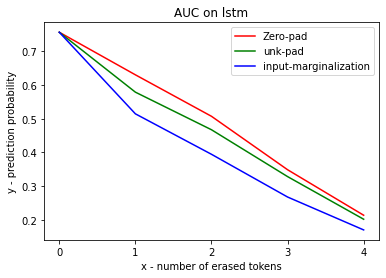

In [245]:

#get the average probability of a class on the 700 sentence
avg_zero = zero_p.mean(0) 
avg_unk = unk_p.mean(0)
avg_mag = mag_p.mean(0)
x = range(5)
  
# plotting the points  
plt.plot(x, avg_zero[:5],'r') 
plt.plot(x,avg_unk[:5],'g')
plt.plot(x,avg_mag[:5],'b') 
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
# naming the x axis 
plt.xlabel('x - number of erased tokens') 
# naming the y axis 
plt.ylabel('y - prediction probability') 
  
# giving a title to my graph 
plt.title('AUC on lstm') 
plt.legend(['Zero-pad','unk-pad','input-marginalization']) 
# function to show the plot 
plt.show() 

In [246]:
print(avg_zero[:4].mean())
print(avg_unk[:4].mean())
print(avg_mag[:4].mean())

0.5608049013848722
0.532860955888022
0.4834183731207148
